# Project : Exploring the UK's rice imports and exports

by Aya Tamura, 21 November, 2023

As an Asian living in the United Kingdom, I often eat rice and appreciate the availability of variety of rice. According to [the Rice Association]('https://www.riceassociation.org.uk/rice-in-the-uk'), rice is not grown in the UK. I wonder where rice comes from to the UK. Is rice cultivated domestically within the UK, or is it solely imported from abroad? In this project, I aim to conduct research on the locales where rice comes from.

# Getting Data

The United Nations (UN) Comtrade database have wide range of global trade data. It shall be leveraged to analyze the UK's rice imports and exports for the year 2022:

- What quantities of rice does the UK export and import, and does a positive balance exist (exports surpassing imports)?
- Which countries constitute the primary trading partners, i.e. from which nations does the UK import most rice, and to which countries are the greatest exports bound?
- Which countries reliably purchase rice from the UK on a monthly basis - the consistent clients?
- Regarding rice, which countries does the UK both import from and export to?

I aim to conduct a judicious study of the UK rice trade sector utilizing UN Comtrade.

Again, the data is obtained from the [United Nations Comtrade](http://comtrade.un.org/data/) website, by selecting the following configuration:

- Type of Product: goods
- Frequency: Monthly 
- Periods: All of 2022
- Reporter: United Kingdom
- Partners: All
- Flows: imports and exports
- HS (as reported) commodity codes: 1006, 100610, 100620, 100630, 100640 (Unprocessed rice)

In [673]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [674]:
LOCATION = 'comtrade_rice_monthly_22.csv'

On reading in the data, the commodity code has to be read as a string, to not lose the leading zero.

In [675]:
rice = pd.read_csv(LOCATION, encoding='latin-1')
rice.head(2)

,TypeCode,FreqCode,RefPeriodId,RefYear,RefMonth,Period,ReporterCode,ReporterISO,ReporterDesc,FlowCode,...,IsNetWgtEstimated,GrossWgt,IsGrossWgtEstimated,Cifvalue,Fobvalue,PrimaryValue,LegacyEstimationFlag,IsReported,IsAggregate,Unnamed: 47
0,C,M,20220101,2022,1,202201,826,GBR,United Kingdom,M,...,False,0,False,44525.184,NaN,44525.184,0,False,True,NaN
1,C,M,20220101,2022,1,202201,826,GBR,United Kingdom,M,...,False,0,False,8479.117,NaN,8479.117,0,False,True,NaN


In [676]:
rice.tail(2)

,TypeCode,FreqCode,RefPeriodId,RefYear,RefMonth,Period,ReporterCode,ReporterISO,ReporterDesc,FlowCode,...,IsNetWgtEstimated,GrossWgt,IsGrossWgtEstimated,Cifvalue,Fobvalue,PrimaryValue,LegacyEstimationFlag,IsReported,IsAggregate,Unnamed: 47
1550,C,M,20221201,2022,12,202212,826,GBR,United Kingdom,X,...,False,0,False,NaN,33998.535,33998.535,0,False,True,NaN
1551,C,M,20221201,2022,12,202212,826,GBR,United Kingdom,X,...,False,0,False,NaN,290.534,290.534,0,False,True,NaN


In [677]:
rice.columns

Index(['TypeCode', 'FreqCode', 'RefPeriodId', 'RefYear', 'RefMonth', 'Period',
       'ReporterCode', 'ReporterISO', 'ReporterDesc', 'FlowCode', 'FlowDesc',
       'PartnerCode', 'PartnerISO', 'PartnerDesc', 'Partner2Code',
       'Partner2ISO', 'Partner2Desc', 'ClassificationCode',
       'ClassificationSearchCode', 'IsOriginalClassification', 'CmdCode',
       'CmdDesc', 'AggrLevel', 'IsLeaf', 'CustomsCode', 'CustomsDesc',
       'MosCode', 'MotCode', 'MotDesc', 'QtyUnitCode', 'QtyUnitAbbr', 'Qty',
       'IsQtyEstimated', 'AltQtyUnitCode', 'AltQtyUnitAbbr', 'AtlQty',
       'IsAltQtyEstimated', 'NetWgt', 'IsNetWgtEstimated', 'GrossWgt',
       'IsGrossWgtEstimated', 'Cifvalue', 'Fobvalue', 'PrimaryValue',
       'LegacyEstimationFlag', 'IsReported', 'IsAggregate', 'Unnamed: 47'],
      dtype='object')

In [678]:
rice.value_counts('CmdDesc')

CmdDesc
Cereals; rice, semi-milled or wholly milled, whether or not polished or glazed    748
Cereals; husked (brown) rice                                                      382
Cereals; rice, broken                                                             294
Cereals; rice in the husk (paddy or rough)                                        128
Name: count, dtype: int64

The data covers the whole 12 months of 2022. Most columns are irrelevant for this analysis, or contain always the same value, like the year and reporter columns. The commodity code is transformed into a short but descriptive text and only the relevant columns are selected.

In [679]:
def riceType(code):
    if code == 100610: # Cereals; rice in the husk (paddy or rough)
        return 'rough' 
    if code == 100620: # Cereals; husked (brown) rice
        return 'brown'
    if code == 100630: # Cereals; rice, semi-milled or wholly milled, whether or not polished or glazed
        return 'milled'
    if code == 100640: # Cereals; rice, broken
        return 'broken'
    return 'unknown'

COMMODITY = 'Rice'
rice[COMMODITY] = rice['CmdCode'].apply(riceType)
MONTH = 'Period'
PARTNER = 'PartnerDesc'
FLOW = 'FlowDesc'
VALUE = 'PrimaryValue'
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
rice = rice[headings]
rice.head()

,Period,PartnerDesc,FlowDesc,Rice,PrimaryValue
0,202201,World,Import,rough,44525.184
1,202201,Bangladesh,Import,rough,8479.117
2,202201,Iran,Import,rough,2400.542
3,202201,Ireland,Import,rough,32479.122
4,202201,Netherlands,Import,rough,1166.403


The data contains the total imports and exports per month, under the 'World' partner. Those rows are removed to keep only the per-country data.

In [680]:
rice = rice[rice[PARTNER] != 'World']
rice.head()

,Period,PartnerDesc,FlowDesc,Rice,PrimaryValue
1,202201,Bangladesh,Import,rough,8479.117
2,202201,Iran,Import,rough,2400.542
3,202201,Ireland,Import,rough,32479.122
4,202201,Netherlands,Import,rough,1166.403
6,202201,Argentina,Import,brown,2079022.784


## Total trade flow

To answer the first question, 'how much does the UK export and import and is the balance positive (more exports than imports)?',
the dataframe is split into two groups: exports from the UK and imports into the UK. The  trade values within each group are summed up to get the total trading.

In [681]:
def roundToThousands (value):
    return round(value / 1000)

In [682]:
grouped = rice.groupby([FLOW])
grouped[VALUE].aggregate(sum).apply(roundToThousands)

FlowDesc
Export     56988
Import    604831
Name: PrimaryValue, dtype: int64

This shows imports exceed exports, the UK has a rice trade deficit and its trade balance is negative about 550 thousands US dollars.

## Main trade partners

To address the second question, 'Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?', the dataframe is split by country instead, and then each group aggregated for the total trade value. This is done separately for imports and exports. The result is sorted in descending order so that the main partners are at the top.

In [683]:
imports = rice[rice[FLOW] == 'Import']
grouped = imports.groupby([PARTNER])
print('The UK imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to the UK are:')
totalImports = grouped[VALUE].aggregate(sum).sort_values(inplace=False,ascending=False).apply(roundToThousands)
totalImports.head()

The UK imports from 55 countries.
The 5 biggest exporters to the UK are:


PartnerDesc
India       161635
Pakistan    100425
Italy        82486
Spain        50999
Uruguay      40660
Name: PrimaryValue, dtype: int64

The export values can be plotted as a bar chart, making differences between countries easier to see.

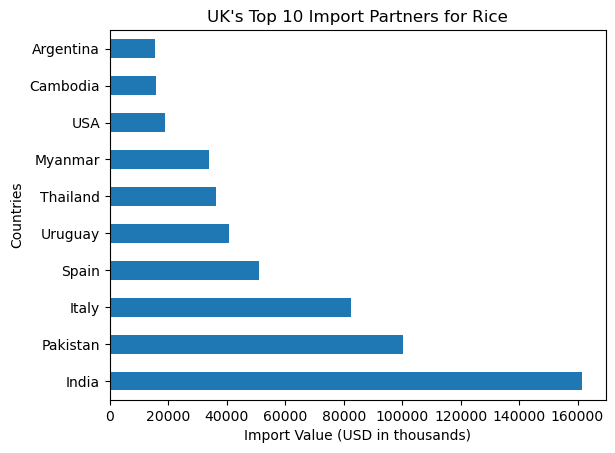

In [684]:
totalImports.head(10).plot(kind='barh')
plt.xlabel("Import Value (USD in thousands)")
plt.ylabel("Countries")
plt.title("UK's Top 10 Import Partners for Rice")
plt.show()

In [685]:
exports = rice[rice[FLOW] == 'Export']
grouped = exports.groupby([PARTNER])
print('The UK exports to', len(grouped), 'countries.')
print('The 5 biggest importers from the UK are:')
totalExports = grouped[VALUE].aggregate(sum).sort_values(ascending=False,inplace=False).apply(roundToThousands)
totalExports.head()

The UK exports to 66 countries.
The 5 biggest importers from the UK are:


PartnerDesc
Ireland        13161
Netherlands    12082
France         11577
Germany         4919
Areas, nes      3327
Name: PrimaryValue, dtype: int64

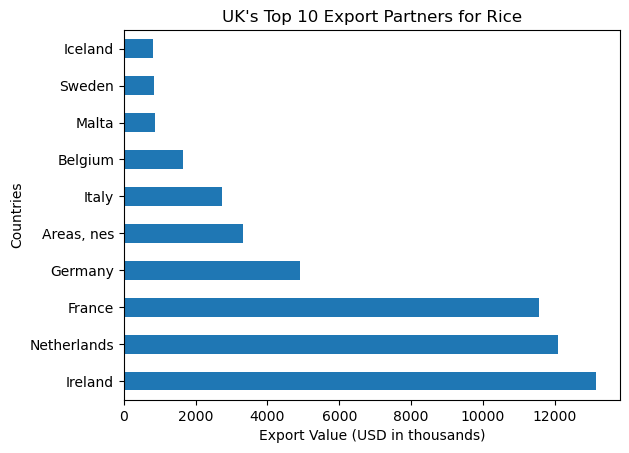

In [686]:
totalExports.head(10).plot(kind='barh')
plt.xlabel("Export Value (USD in thousands)")
plt.ylabel("Countries")
plt.title("UK's Top 10 Export Partners for Rice")
plt.show()

## Regular partners

The third question, 'Which are the regular customers, i.e. which countries buy rice from the UK and sell to the UK every month?', is meant in the sense that a regular customer imports both commodities every month. This means that if the import/exports dataframe is grouped by country, each group has more than 36 rows at least (at least three kinds of rice were bought/sold each of the 12 months). To see the countries, only the first month of one commodity has to be listed, as by definition it's the same countries every month and for the other commodity.

In [687]:
def buysEveryMonth(group):
    return len(group) >= 36

grouped = exports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular

,Period,PartnerDesc,FlowDesc,Rice,PrimaryValue
77,202201,Ireland,Export,rough,2483.180
81,202201,Belgium,Export,brown,998.420
84,202201,Ireland,Export,brown,73704.237
86,202201,Italy,Export,brown,345.451
88,202201,Netherlands,Export,brown,5582.751
...,...,...,...,...,...
1541,202212,"Areas, nes",Export,milled,258565.138
1546,202212,Ireland,Export,broken,17.090
1547,202212,Italy,Export,broken,87091.719
1548,202212,Netherlands,Export,broken,1142.603


In [688]:
regular[(regular[MONTH] == 202201)]

,Period,PartnerDesc,FlowDesc,Rice,PrimaryValue
77,202201,Ireland,Export,rough,2483.180
81,202201,Belgium,Export,brown,998.420
84,202201,Ireland,Export,brown,73704.237
86,202201,Italy,Export,brown,345.451
88,202201,Netherlands,Export,brown,5582.751
89,202201,"Areas, nes",Export,brown,2401.897
93,202201,Belgium,Export,milled,45056.230
102,202201,Ireland,Export,milled,556886.546
104,202201,Italy,Export,milled,67510.513
106,202201,Netherlands,Export,milled,372155.869


In [689]:
regular[VALUE].sum() / exports[VALUE].sum()

0.5782908092318815

In [690]:
def buysEveryMonth(group):
    return len(group) >= 36

grouped = imports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular


,Period,PartnerDesc,FlowDesc,Rice,PrimaryValue
3,202201,Ireland,Import,rough,32479.122
4,202201,Netherlands,Import,rough,1166.403
14,202201,Ireland,Import,brown,2244.751
16,202201,Netherlands,Import,brown,6969.972
20,202201,India,Import,brown,9074246.633
...,...,...,...,...,...
1488,202212,Ireland,Import,broken,220.952
1491,202212,Netherlands,Import,broken,2158.250
1494,202212,India,Import,broken,47861.138
1496,202212,Spain,Import,broken,532979.006


In [691]:
regular[(regular[MONTH] == 202201)]

,Period,PartnerDesc,FlowDesc,Rice,PrimaryValue
3,202201,Ireland,Import,rough,32479.122
4,202201,Netherlands,Import,rough,1166.403
14,202201,Ireland,Import,brown,2244.751
16,202201,Netherlands,Import,brown,6969.972
20,202201,India,Import,brown,9074246.633
22,202201,Spain,Import,brown,167783.282
23,202201,Thailand,Import,brown,271096.015
40,202201,Ireland,Import,milled,38301.656
47,202201,Netherlands,Import,milled,33920.531
52,202201,India,Import,milled,6781056.724


In [692]:
regular[VALUE].sum() / imports[VALUE].sum()

0.4165164856428899

As for exports, the regular export partners are Ireland, Netherlands, Belgium, and Italy. More than 57% of the exports can be attributed to these countries.
Regarding imports, in addition to the regular export partners of Ireland and Netherlands, India, Spain, and Thailand are also significant import partners. These regular customers account for approximately 41% of the total UK imports.

## Bi-directional trade

To address the fourth question, 
'Which countries does the UK both import from and export to?', a pivot table is used to list the total export and import value for each country. 

In [693]:
countries = pd.pivot_table(rice, index=[PARTNER], columns=[FLOW], 
                        values=VALUE, aggfunc=sum)
countries.head()

FlowDesc,Export,Import
PartnerDesc,,
Antarctica,17417.400,NaN
"Areas, nes",3326775.751,NaN
Argentina,11808.178,1.553813e+07
Australia,161640.196,2.879119e+06
Austria,154112.827,2.075998e+03


Removing the rows with a missing value will result in only those countries with bi-directional trade flow with the UK.

In [695]:
countries.dropna().apply(roundToThousands)

FlowDesc,Export,Import
PartnerDesc,,
Argentina,12.0,15538.0
Australia,162.0,2879.0
Austria,154.0,2.0
Bangladesh,0.0,688.0
Belgium,1640.0,1843.0
Bulgaria,6.0,162.0
Cambodia,0.0,15703.0
"China, Hong Kong SAR",73.0,113.0
Egypt,9.0,7.0


## Conclusions

The rice trade of the UK from January to December 2022 was analysed in terms of which countries the UK mostly depends on for income (exports) and goods (imports). Over the period, the UK had a trade negative of over 550 thousands US dollars.

From above, Ireland is the main partner, but it imported from the UK almost the triple in value than it exported to the UK. 

The UK exported to over 100 countries during the period, but only imported from 21 countries, the main ones (top five by trade value) being geographically close. China and Hong Kong are the main importers that are not also main exporters. 

The UK is heavily dependent on its regular customers, the 16 countries that buy all types of milk and cream every month. They contribute three quarters of the total export value.

The UK has bi-directional trade (i.e. both exports and imports) with 20 countries, although for some the trade value (in US dollars) is suspiciously low, which raises questions about the data's accuracy.